In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12,6)

In [4]:
X_full = pd.read_csv('D:\datasets\Phishing_Legitimate_full.csv', index_col='id')

In [5]:
#Check on missing values
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   NumDots                             10000 non-null  int64  
 1   SubdomainLevel                      10000 non-null  int64  
 2   PathLevel                           10000 non-null  int64  
 3   UrlLength                           10000 non-null  int64  
 4   NumDash                             10000 non-null  int64  
 5   NumDashInHostname                   10000 non-null  int64  
 6   AtSymbol                            10000 non-null  int64  
 7   TildeSymbol                         10000 non-null  int64  
 8   NumUnderscore                       10000 non-null  int64  
 9   NumPercent                          10000 non-null  int64  
 10  NumQueryComponents                  10000 non-null  int64  
 11  NumAmpersand                        10000

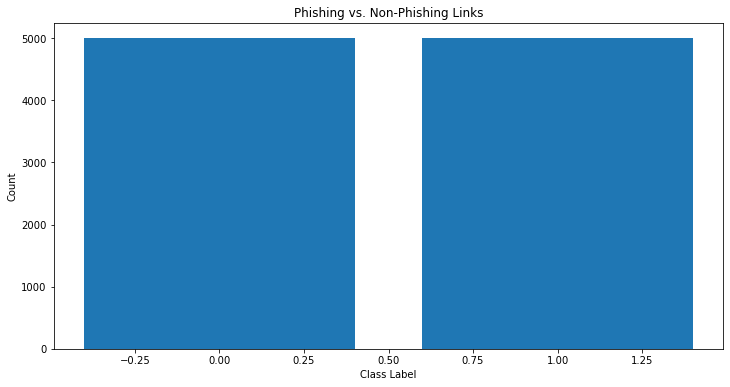

In [6]:
#Chek target value balance
class_counts = X_full['CLASS_LABEL'].value_counts()

# Create a bar chart
plt.bar(class_counts.index, class_counts.values)

# Add labels and title
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Phishing vs. Non-Phishing Links')

# Display the chart
plt.show()

In [7]:
correlation_matrix = X_full.corr()

In [8]:
#Make list of most correlated features for logistic regression
changed_correl_matrix = abs(correlation_matrix.CLASS_LABEL)
changed_correl_matrix = changed_correl_matrix.drop('CLASS_LABEL')
changed_correl_matrix.sort_values(ascending=False).head()

PctExtNullSelfRedirectHyperlinksRT    0.540545
FrequentDomainNameMismatch            0.463956
NumDash                               0.372235
SubmitInfoToEmail                     0.357635
PctNullSelfRedirectHyperlinks         0.342806
Name: CLASS_LABEL, dtype: float64

In [13]:
#Create a function to identify optimal number of features for the best model accuracy
def train_logistic(data, n_features):
    most_correl_features = changed_correl_matrix.sort_values(ascending=False).head(n_features).index.tolist()
    X = data[most_correl_features]
    y = data['CLASS_LABEL']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    lr = LogisticRegression(max_iter=10000)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    return precision, recall, f1, accuracy

In [14]:
#Create an array with the number of features and the corresponding model estimates
arr_logistic = []
for i in range(20,48,1):
    precision, recall, f1, accuracy = train_logistic(X_full, i)
    arr_logistic.append([i, precision, recall, f1, accuracy])

In [15]:
#Show number of features sorted by averrage of estimates
est_logistic = pd.DataFrame(arr_logistic, columns=['num_of_features', 'precision', 'recall', 'f1_score', 'accuracy'])
est_logistic['avg'] = est_logistic[['precision', 'recall', 'f1_score', 'accuracy']].mean(axis=1)
est_logistic.sort_values('avg', ascending=False).head()

,num_of_features,precision,recall,f1_score,accuracy,avg
23,43,0.937736,0.956689,0.947118,0.9445,0.946511
16,36,0.931507,0.954865,0.943041,0.9425,0.942978
15,35,0.930703,0.954590,0.942495,0.9410,0.942197
24,44,0.935231,0.949203,0.942165,0.9415,0.942025
25,45,0.928072,0.949898,0.938858,0.9395,0.939082


<AxesSubplot:title={'center':'Logistic Regression Estimates'}, xlabel='Features number', ylabel='Estimates'>

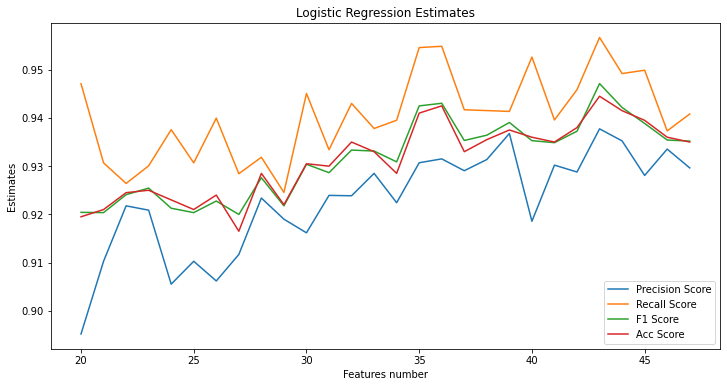

In [16]:
#Draw a linear graph of model efficiency depending on the number of features
plt.title("Logistic Regression Estimates")
plt.xlabel("Features number")
plt.ylabel("Estimates")
sns.lineplot(x='num_of_features', y='precision', data=est_logistic, label='Precision Score')
sns.lineplot(x='num_of_features', y='recall', data=est_logistic, label='Recall Score')
sns.lineplot(x='num_of_features', y='f1_score', data=est_logistic, label='F1 Score')
sns.lineplot(x='num_of_features', y='accuracy', data=est_logistic, label='Acc Score')

In [ ]:
#The choice of the most effective number of features is based not only on a high average score, 
#but more importantly on the high value of each individual score. Because the model can have a maximum 
#percentage of positive class detection and at the same time make many mistakes in detecting the negative class or etc.


In [17]:
#Create a function to find the best SVC model kernel for our data
def train_SVC(data, kernel):
    X = X_full.drop('CLASS_LABEL', axis=1)
    y = X_full.CLASS_LABEL
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    svc_model = SVC(kernel=kernel)
    svc_model.fit(X_train, y_train)
    
    y_pred = svc_model.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return precision, recall, f1, accuracy

In [18]:
arr_svc = []
for i in ['linear', 'rbf', 'poly', 'sigmoid']:
    precision, recall, f1, accuracy = train_SVC(X_full, i)
    arr_svc.append([i, precision, recall, f1, accuracy])

In [19]:
df_svc = pd.DataFrame(arr_svc, columns=['kernel', 'precision', 'recall', 'f1_score', 'accuracy'])
df_svc['avg'] = df_svc[['precision', 'recall', 'f1_score', 'accuracy']].mean(axis=1)
df_svc.sort_values('avg', ascending=False).head()

,kernel,precision,recall,f1_score,accuracy,avg
0,linear,0.934967,0.956606,0.945663,0.9430,0.945059
1,rbf,0.814298,0.913894,0.861226,0.8495,0.859730
2,poly,0.666436,0.971803,0.790660,0.7445,0.793350
3,sigmoid,0.571566,0.607143,0.588817,0.5845,0.588007


In [32]:
#Create a list of most important features for no regression models
X = X_full.drop('CLASS_LABEL', axis=1)
y = X_full.CLASS_LABEL
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
most_imp_features = mi_scores.sort_values(ascending=False).head(-8).index.tolist() #drop features with 0 score
mi_scores

PctExtHyperlinks                      0.471469
PctExtResourceUrls                    0.292629
PctNullSelfRedirectHyperlinks         0.229719
PctExtNullSelfRedirectHyperlinksRT    0.209907
NumNumericChars                       0.127606
FrequentDomainNameMismatch            0.124134
ExtMetaScriptLinkRT                   0.120555
NumDash                               0.111638
SubmitInfoToEmail                     0.073190
NumDots                               0.063256
InsecureForms                         0.059672
PathLength                            0.057152
PathLevel                             0.052519
QueryLength                           0.047272
UrlLength                             0.042773
NumSensitiveWords                     0.041183
IframeOrFrame                         0.032376
NumQueryComponents                    0.030679
PctExtResourceUrlsRT                  0.029075
HostnameLength                        0.028441
RandomString                          0.016094
UrlLengthRT  

In [21]:
#Identify optimal number of features for decision tree
def train_dtc(data, top_n):
    top_n_features = mi_scores.sort_values(ascending=False).head(top_n).index.tolist()
    X = data[top_n_features]
    y = data['CLASS_LABEL']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    dt = DecisionTreeClassifier(max_depth=32, 
                                max_features=1.0)
    
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    return precision, recall, f1, accuracy

In [23]:
arr_dtc = []
for i in range(20,41,1):
    precision, recall, f1, accuracy = train_dtc(X_full, i)
    arr_dtc.append([i, precision, recall, f1, accuracy])

In [24]:
df_dtc = pd.DataFrame(arr_dtc, columns=['num_of_features', 'precision', 'recall', 'f1_score', 'accuracy'])
df_dtc['avg'] = df_dtc[['precision', 'recall', 'f1_score', 'accuracy']].mean(axis=1)
df_dtc.sort_values('avg', ascending=False).head()

,num_of_features,precision,recall,f1_score,accuracy,avg
1,21,0.967197,0.975928,0.971543,0.9715,0.971542
10,30,0.969844,0.972683,0.971262,0.9705,0.971072
17,37,0.970238,0.969277,0.969757,0.9695,0.969693
15,35,0.963902,0.971485,0.967679,0.9670,0.967516
19,39,0.959024,0.976167,0.967520,0.9670,0.967428


<AxesSubplot:title={'center':'Decision Tree Classifier Estimates'}, xlabel='Features number', ylabel='Estimates'>

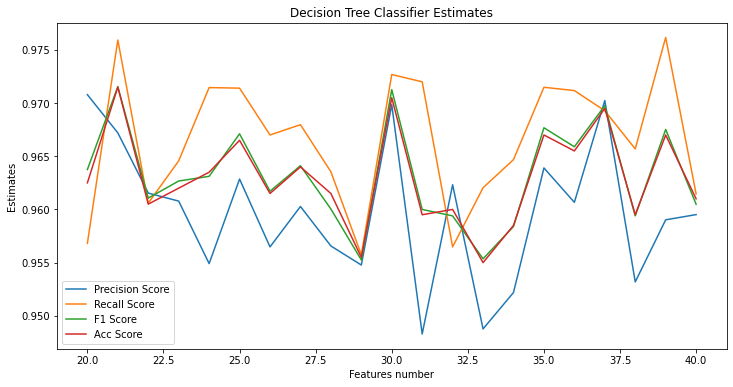

In [25]:
plt.title("Decision Tree Classifier Estimates")
plt.xlabel("Features number")
plt.ylabel("Estimates")
sns.lineplot(x='num_of_features', y='precision', data=df_dtc, label='Precision Score')
sns.lineplot(x='num_of_features', y='recall', data=df_dtc, label='Recall Score')
sns.lineplot(x='num_of_features', y='f1_score', data=df_dtc, label='F1 Score')
sns.lineplot(x='num_of_features', y='accuracy', data=df_dtc, label='Acc Score')

In [26]:
#Identify optimal number of features for random forest
def train_rfc(data, top_n):
    top_n_features = mi_scores.sort_values(ascending=False).head(top_n).index.tolist()
    X = data[top_n_features]
    y = data['CLASS_LABEL']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    rfc = RandomForestClassifier(n_estimators=500,  
                max_depth=32, 
                max_features=1.0,
                n_jobs=4
                )
    
    rfc.fit(X_train, y_train)
    
    y_pred = rfc.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    return precision, recall, f1, accuracy

In [27]:
arr_rfc = []
for i in range(20,41,1):
    precision, recall, f1, accuracy = train_rfc(X_full, i)
    arr_rfc.append([i, precision, recall, f1, accuracy])

In [28]:
df_rfc = pd.DataFrame(arr_rfc, columns=['num_of_features', 'precision', 'recall', 'f1_score', 'accuracy'])
df_rfc['avg'] = df_rfc[['precision', 'recall', 'f1_score', 'accuracy']].mean(axis=1)
df_rfc.sort_values('avg', ascending=False).head()

,num_of_features,precision,recall,f1_score,accuracy,avg
16,36,0.986987,0.982072,0.984523,0.9845,0.984520
18,38,0.981336,0.987154,0.984236,0.9840,0.984182
13,33,0.982125,0.982125,0.982125,0.9820,0.982094
12,32,0.982507,0.977756,0.980126,0.9795,0.979972
19,39,0.974359,0.984064,0.979187,0.9790,0.979153


<AxesSubplot:title={'center':'Random Forest Classifier Estimates'}, xlabel='Features number', ylabel='Estimates'>

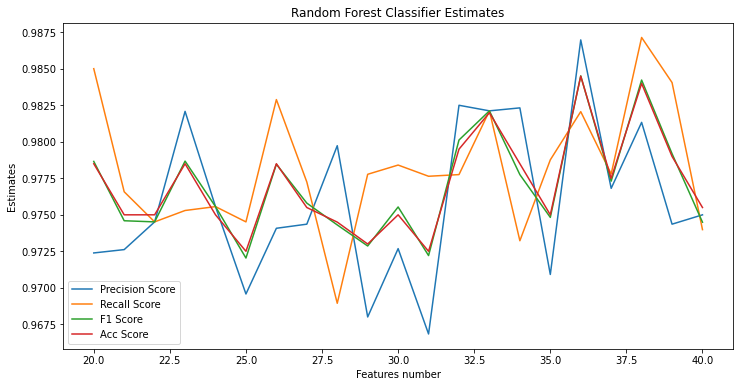

In [29]:
plt.title("Random Forest Classifier Estimates")
plt.xlabel("Features number")
plt.ylabel("Estimates")
sns.lineplot(x='num_of_features', y='precision', data=df_rfc, label='Precision Score')
sns.lineplot(x='num_of_features', y='recall', data=df_rfc, label='Recall Score')
sns.lineplot(x='num_of_features', y='f1_score', data=df_rfc, label='F1 Score')
sns.lineplot(x='num_of_features', y='accuracy', data=df_rfc, label='Acc Score')

In [ ]:
#Test the effectiveness of the most popular classification models on our data
##Selecting the number of features for other types of models woun't give significant improvements 

In [62]:
xgb_model = xgb.XGBClassifier(n_estimators=800, learning_rate=0.05, n_jobs=4)
dt_model = DecisionTreeClassifier(max_depth=32, max_features=1.0)
rf_model = RandomForestClassifier(n_estimators=500, max_depth=32, max_features=1.0, n_jobs=4)
lr_model = LogisticRegression(max_iter=10000)
gb_model = GradientBoostingClassifier()
ab_model = AdaBoostClassifier()
svm_model = SVC(kernel='linear')
gnb_model = GaussianNB()

In [63]:
#for new models
X_train, X_test, y_train, y_test = train_test_split(X[most_imp_features], y, test_size=0.2, random_state=42)
xgb_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
ab_model.fit(X_train, y_train)
gnb_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [65]:
#using best features number
#Logistic Regression 
top_features_lr = changed_correl_matrix.sort_values(ascending=False).head(36).index.tolist()
Xlr = X_full[top_features_lr]
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(Xlr, y, test_size=0.2, random_state=42)
lr_model.fit(X_train_lr, y_train_lr)

#Decision Tree Classifier
top_features_dtc = mi_scores.sort_values(ascending=False).head(30).index.tolist()
Xdtc = X_full[top_features_dtc]
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(Xdtc, y, test_size=0.2, random_state=42)
dt_model.fit(X_train_dtc, y_train_dtc)

#Random Forest Classifier
top_features_rfc = mi_scores.sort_values(ascending=False).head(33).index.tolist()
Xrfc = X_full[top_features_rfc]
X_train_rfc, X_test_rfc, y_train_rfc, y_test_rfc = train_test_split(Xrfc, y, test_size=0.2, random_state=42)
rf_model.fit(X_train_rfc, y_train_rfc)

RandomForestClassifier(max_depth=32, max_features=1.0, n_estimators=500,
                       n_jobs=4)

In [66]:
#Prediction
xgb_pred = xgb_model.predict(X_test)
dt_pred = dt_model.predict(X_test_dtc)
rf_pred = rf_model.predict(X_test_rfc)
lr_pred = lr_model.predict(X_test_lr)
gb_pred = gb_model.predict(X_test)
ab_pred = ab_model.predict(X_test)
svm_pred = svm_model.predict(X_test)
gnb_pred = gnb_model.predict(X_test)

In [67]:
# Evaluating the models
xgb_accuracy = accuracy_score(y_test, xgb_pred)
dt_accuracy = accuracy_score(y_test_dtc, dt_pred)
rf_accuracy = accuracy_score(y_test_rfc, rf_pred)
lr_accuracy = accuracy_score(y_test_lr, lr_pred)
gb_accuracy = accuracy_score(y_test, gb_pred)
ab_accuracy = accuracy_score(y_test, ab_pred)
svm_accuracy = accuracy_score(y_test, svm_pred)
gnb_accuracy = accuracy_score(y_test, gnb_pred)

In [68]:
print("XGBoost Accuracy:", xgb_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)
print("Gradient Boosting Accuracy:", gb_accuracy)
print("AdaBoost Accuracy:", ab_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("GaussianNB Accuracy:", gnb_accuracy)

XGBoost Accuracy: 0.989
Decision Tree Accuracy: 0.9635
Random Forest Accuracy: 0.975
Logistic Regression Accuracy: 0.9385
Gradient Boosting Accuracy: 0.9805
AdaBoost Accuracy: 0.9725
SVM Accuracy: 0.9375
GaussianNB Accuracy: 0.8405


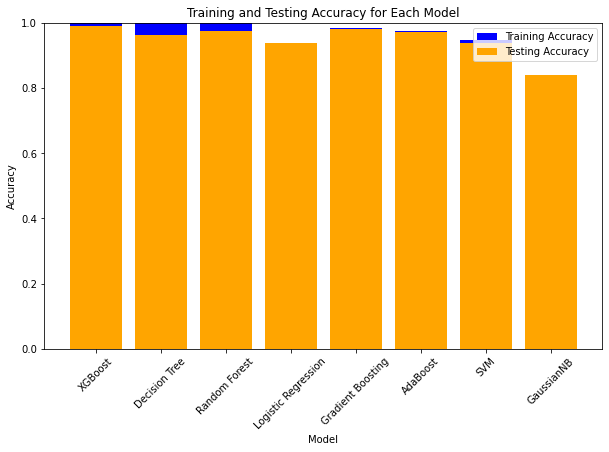

In [69]:
# Create a list of models and their corresponding accuracy scores
models = ['XGBoost', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Gradient Boosting', 'AdaBoost', 'SVM', 'GaussianNB']
train_accuracies = [xgb_model.score(X_train, y_train), dt_model.score(X_train_dtc, y_train_dtc), rf_model.score(X_train_rfc, y_train_rfc), lr_model.score(X_train_lr, y_train_lr), gb_model.score(X_train, y_train), ab_model.score(X_train, y_train), svm_model.score(X_train, y_train), gnb_model.score(X_train, y_train)]
test_accuracies = [xgb_accuracy, dt_accuracy, rf_accuracy, lr_accuracy, gb_accuracy, ab_accuracy, svm_accuracy, gnb_accuracy]

# Plot the training and testing accuracy for each model
plt.figure(figsize=(10, 6))
plt.bar(models, train_accuracies, color='blue', label='Training Accuracy')
plt.bar(models, test_accuracies, color='orange', label='Testing Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy for Each Model')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [70]:
# Stacking Classifier
estimators = [('xgb', xgb_model), ('gb', gb_model), ('ab', ab_model)]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=lr_model, cv=5)
stacking_model.fit(X_train, y_train)
stacking_pred = stacking_model.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_pred)
print("Stacking Classifier Accuracy:", stacking_accuracy)

Stacking Classifier Accuracy: 0.9875


In [72]:
# Voting Classifier
voting_model = VotingClassifier(estimators=estimators)
voting_model.fit(X_train, y_train)
voting_pred = voting_model.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_pred)
print("Voting Classifier Accuracy:", voting_accuracy)

Voting Classifier Accuracy: 0.9835


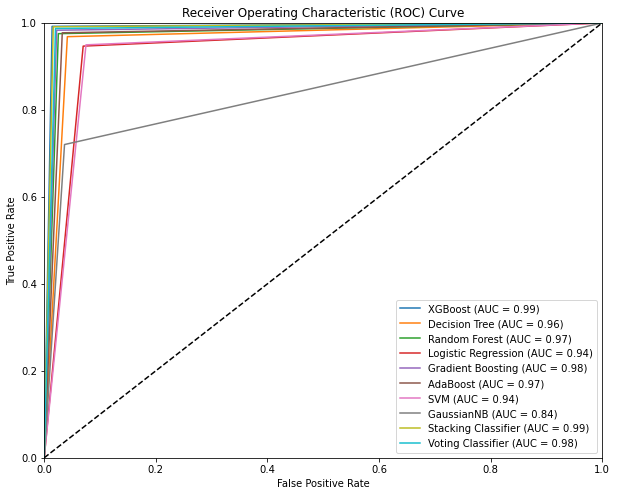

In [74]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# Define a list of models and their corresponding predictions
models = ['XGBoost', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Gradient Boosting', 'AdaBoost', 'SVM', 'GaussianNB', 'Stacking Classifier', 'Voting Classifier']
predictions = [xgb_pred, dt_pred, rf_pred, lr_pred, gb_pred, ab_pred, svm_pred, gnb_pred, stacking_pred, voting_pred]

# Plot ROC curves for each model
plt.figure(figsize=(10, 8))
for model, prediction in zip(models, predictions):
    fpr, tpr, _ = roc_curve(y_test, prediction)
    auc = roc_auc_score(y_test, prediction)
    plt.plot(fpr, tpr, label=model + ' (AUC = {:.2f})'.format(auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [76]:
# Print confusion matrix report for each model
for model, prediction in zip(models, predictions):
    cm = confusion_matrix(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    
    print("Model:", model)
    print("Confusion Matrix:")
    print(cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("------------------------------")

Model: XGBoost
Confusion Matrix:
[[ 974   14]
 [   8 1004]]
Accuracy: 0.989
Precision: 0.9862475442043221
Recall: 0.9920948616600791
F1 Score: 0.9891625615763547
------------------------------
Model: Decision Tree
Confusion Matrix:
[[947  41]
 [ 32 980]]
Accuracy: 0.9635
Precision: 0.9598432908912831
Recall: 0.9683794466403162
F1 Score: 0.9640924741760944
------------------------------
Model: Random Forest
Confusion Matrix:
[[963  25]
 [ 25 987]]
Accuracy: 0.975
Precision: 0.9752964426877471
Recall: 0.9752964426877471
F1 Score: 0.9752964426877471
------------------------------
Model: Logistic Regression
Confusion Matrix:
[[919  69]
 [ 54 958]]
Accuracy: 0.9385
Precision: 0.9328140214216164
Recall: 0.9466403162055336
F1 Score: 0.9396763119176067
------------------------------
Model: Gradient Boosting
Confusion Matrix:
[[966  22]
 [ 17 995]]
Accuracy: 0.9805
Precision: 0.9783677482792527
Recall: 0.983201581027668
F1 Score: 0.980778708723509
------------------------------
Model: AdaBoost


In [ ]:
#Conclusion.
#Almost all models showed a higher sensitivity to detecting non-phishing sites (TN). 
#The best of them for this dataset is the XGBoost model.